# Neural Caption Image Generator

In this notebook I define and train an image-to-caption model, that can produce descriptions for real world images!

This work is based on this paper [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555) by Oriol Vinyals, Alexander Toshev, Samy Bengio and Dumitru Erhan. The authors combined recent computer vision and language models into a single jointly trained system, taking an image and directly producing a human readable sequence of words to describe it.

So the model use a deep CNN for vision and RNN for language generation.

In [1]:
import os
import re
import time
import json
import tqdm
import pickle
import random
import zipfile
import unicodedata
import collections

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

1.15.0


## Download data

In [2]:
if not os.path.exists('./data'):
    os.mkdir('./data')

!wget --no-check-certificate \
    "http://msvocds.blob.core.windows.net/coco2014/train2014.zip" \
    -O "./data/train.zip"
!wget --no-check-certificate \
    "http://msvocds.blob.core.windows.net/coco2014/val2014.zip" \
    -O "./data/val.zip"
!wget --no-check-certificate \
    "http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip" \
    -O "./data/caption.zip"

for local_zip in ['./data/train.zip', './data/val.zip', './data/caption.zip']:
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('./data')
    zip_ref.close()
    
    !rm -r {local_zip}

--2020-01-09 00:38:15--  http://msvocds.blob.core.windows.net/coco2014/train2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 52.176.224.96
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|52.176.224.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/octet-stream]
Saving to: ‘./data/train.zip’

./data/train.zip    100%[===================>]  12.58G  14.7MB/s    in 13m 3s  

2020-01-09 00:51:18 (16.5 MB/s) - ‘./data/train.zip’ saved [13510573713/13510573713]

--2020-01-09 00:51:18--  http://msvocds.blob.core.windows.net/coco2014/val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 52.176.224.96
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|52.176.224.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/octet-stream]
Saving to: ‘./data/val.zip’

./data/val.

In [3]:
print('Number of training images:', len(os.listdir('./data/train2014')))
print('Number of validating images:', len(os.listdir('./data/val2014')))

Number of training images: 82783
Number of validating images: 40504


In [4]:
def load_caption(filename):
    with open(filename) as captions:
        data = json.load(captions)
        image_id_to_image_filename = {
            item['id']: item['file_name'] for item in data['images']}
        image_filename_to_image_captions = collections.defaultdict(list)
        for item in data['annotations']:
            image_filename_to_image_captions[
                image_id_to_image_filename[item['image_id']]].append(
                    item['caption'].strip())
        return image_filename_to_image_captions

train_captions = load_caption('./data/annotations/captions_train2014.json')
valid_captions = load_caption('./data/annotations/captions_val2014.json')

print('Number of training captions:', len(train_captions))
print('Number of validating captions:', len(valid_captions))

Number of training captions: 82783
Number of validating captions: 40504


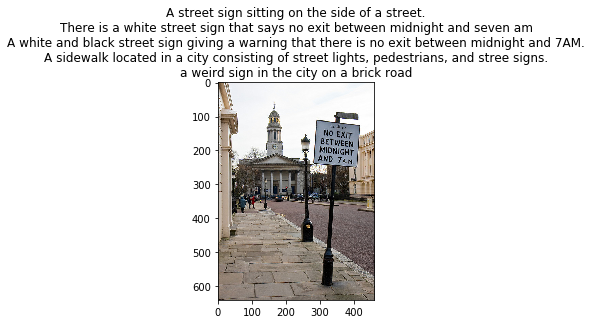

In [5]:
def show_random_training_example(captions):
    idx = np.random.randint(0, len(captions))
    image_filename = os.listdir('./data/train2014')[idx]
    image = cv2.imread('./data/train2014/' + image_filename, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    plt.title('\n'.join(captions[image_filename]))
    plt.show()

show_random_training_example(train_captions)

# Process captions for training

In [8]:
def unicode_to_ascii(s):
    # NFD => Normal Form Decompose
    # Mn => Non Marking Space
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                    if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    # Replace any of '.', '!', '?' by ' .', ' !', ' ?'.
    # \1 means the 1st bracked group. r is to not consider \1
    s = re.sub(r"([',.!?])", r' \1 ', s)
    # Remove any character which is not in [^a-zA-Z.!?]
    s = re.sub(r"[^a-zA-Z1-9',.!?]", r' ', s)
    # Remove a sequence of whitespace characters
    s = re.sub(r'\s+', r' ', s)
    return s

unicode_to_ascii('Montréal, Françoise...'), normalize_string("aa isn't 123 aa!s^s dd?")

('Montreal, Francoise...', "aa isn ' t 123 aa ! s s dd ? ")

In [9]:
captions = []
for image in tqdm.tqdm(os.listdir('./data/train2014'),
                       'Get all image captions in a list'):
    for caption in train_captions[image]:
        captions.append(normalize_string(caption))
        
captions[:3]

Get all image captions in a list: 100%|██████████| 82783/82783 [00:11<00:00, 7109.33it/s]


['some people riding motorcycles on the streets with others . ',
 'two people driving motorcycles down a city street , one riding with a child . ',
 'a man and a woman on their scooters riding down the road . ']

In [10]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3

class Vocabulary:

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = {PAD_TOKEN: 'PAD',
                           SOS_TOKEN: 'SOS',
                           EOS_TOKEN: 'EOS',
                           UNK_TOKEN: 'UNK'}
        self.word2count = {}
        self.num_words = 4

    def add_word(self, word):
        if word in self.word2count.keys():
            self.word2count[word] += 1
        else:
            self.word2index[word] = self.num_words
            self.index2word[self.num_words] = word
            self.word2count[word] = 1
            self.num_words +=1

    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def trim(self, min_count):
        '''Remove words below a certain count threshold'''
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)
        
        print(f'Keeping {len(keep_words)} over {len(self.word2index)} '
                f'=> {(len(keep_words) / len(self.word2index) * 100):.2f}%')
        
        self.word2index = {}
        self.index2word = {PAD_TOKEN: 'PAD',
                           SOS_TOKEN: 'SOS',
                           EOS_TOKEN: 'EOS',
                           UNK_TOKEN: 'UNK'}
        self.word2count = {}
        self.num_words = 4
        
        for word in keep_words:
            self.add_word(word)

In [11]:
vocab = Vocabulary(name='image captioning')
for caption in tqdm.tqdm(captions, 'Build a vocabulary'):
    vocab.add_sentence(caption)

Build a vocabulary: 100%|██████████| 414113/414113 [00:02<00:00, 164774.89it/s]


In [12]:
vocab.trim(min_count=5)
print('Length of the vocabulary', vocab.num_words)

Keeping 8762 over 23053 => 38.01%
Length of the vocabulary 8766


In [22]:
def captions_to_sequences(image_captions, vocabulary):
    image_caption_sequences = {}
    for image, captions in tqdm.tqdm(image_captions.items(),
                                     'Convert image captions to sequences'):
        caption_sequences = []
        for caption in captions:
            sequence = [vocabulary.word2index[word]
                        if word in vocabulary.word2index 
                        else UNK_TOKEN 
                        for word in normalize_string(caption).split()]
            caption_sequences.append([SOS_TOKEN] + sequence + [EOS_TOKEN])
        image_caption_sequences[image] = caption_sequences
    return image_caption_sequences

train_caption_sequences = captions_to_sequences(train_captions, vocab)
valid_caption_sequences = captions_to_sequences(valid_captions, vocab)

Convert image captions to sequences: 100%|██████████| 40504/40504 [00:07<00:00, 5705.86it/s]


In [23]:
train_caption_sequences['COCO_train2014_000000134754.jpg']

[[1, 9, 14, 5, 29, 68, 16, 9, 394, 13, 2],
 [1, 14, 5, 367, 359, 2013, 8, 17, 394, 13, 2],
 [1, 14, 1936, 62, 17, 58, 3, 394, 11, 2617, 13, 2],
 [1, 17, 33, 62, 9, 394, 68, 11, 26, 359, 2013, 13, 2],
 [1, 17, 544, 24, 17, 398, 29, 68, 8, 9, 394, 231, 2617, 13, 2]]

In [31]:
def pad_sequences(sequences):
    sequences_padded = []
    max_len = max(map(len, sequences))
    for sequence in sequences:
        if len(sequence) < max_len:
            pad = [PAD_TOKEN for _ in range(max_len - len(sequence))]
            sequences_padded.append(sequence + pad)
        else:
            sequences_padded.append(sequence)
    return np.array(sequences_padded)

In [64]:
pad_sequences(train_caption_sequences['COCO_train2014_000000134754.jpg'])

array([[   1,    9,   14,    5,   29,   68,   16,    9,  394,   13,    2,
           0,    0,    0,    0],
       [   1,   14,    5,  367,  359, 2013,    8,   17,  394,   13,    2,
           0,    0,    0,    0],
       [   1,   14, 1936,   62,   17,   58,    3,  394,   11, 2617,   13,
           2,    0,    0,    0],
       [   1,   17,   33,   62,    9,  394,   68,   11,   26,  359, 2013,
          13,    2,    0,    0],
       [   1,   17,  544,   24,   17,  398,   29,   68,    8,    9,  394,
         231, 2617,   13,    2]])

In [74]:
def sequences_to_texts(sequences, vocabulary):
    texts = []
    for sequence in sequences:
        text = [*map(lambda index: vocabulary.index2word[index], sequence.tolist())]
        texts.append(' '.join(text))
    return texts

In [75]:
sequences_to_texts(pad_sequences(train_caption_sequences['COCO_train2014_000000134754.jpg']), vocab)

['SOS the two people are walking down the beach . EOS PAD PAD PAD PAD',
 'SOS two people carrying surf boards on a beach . EOS PAD PAD PAD PAD',
 'SOS two teenagers at a white UNK beach with surfboards . EOS PAD PAD PAD',
 'SOS a couple at the beach walking with their surf boards . EOS PAD PAD',
 'SOS a guy and a girl are walking on the beach holding surfboards . EOS']

## Model Architecture

In [34]:
def reset_tf_session():
    current_session = tf.get_default_session()
    if current_session is not None: # Close the current session
        current_session.close()
    K.clear_session() # Reset graph
    # Create a new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.InteractiveSession(config=config)
    K.set_session(session)
    return session

def image_center_crop(image):
    height, width, _ = image.shape
    size = min(width, height)
    pad_h, pad_w = (height - size) // 2, (width - size) // 2
    image_cropped = image[pad_h:pad_h + size, pad_w:pad_w + size, :]
    assert image_cropped.shape[0] == image_cropped.shape[1], f'Error in cropping image! {image_cropped.shape}'
    return image_cropped

def image_process(image, shape, preprocess_for_model):
    image = image_center_crop(image)
    image = cv2.resize(image, shape)
    image = image.astype('float32')
    image = preprocess_for_model(image)
    return image

def encode_images(images_path, shape, model, preprocess_for_model):
    encoded_images, filename_images = [], []
    for image_filename in tqdm.tqdm(os.listdir(images_path), f'Encode images in {images_path}'):
        image = cv2.imread(images_path + image_filename, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image_process(image, shape, preprocess_for_model)
        encoded_image = model.predict(np.expand_dims(image, axis=0)) # Input image shape: (None, w, h, c)
        encoded_images.append(encoded_image)
        filename_images.append(image_filename)
    encoded_images = np.vstack(encoded_images)
    return encoded_images, filename_images

def save_pickle(obj, path):
    with open(path, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(path):
    with open(path, 'rb') as pickle_file:
        return pickle.load(pickle_file)

def get_encoder():
    K.set_learning_phase(False)
    base_model = keras.applications.InceptionV3(include_top=False)
    model = keras.models.Model(inputs=base_model.input,
                               outputs=L.GlobalAveragePooling2D()(base_model.output))
    return model, keras.applications.inception_v3.preprocess_input

In [35]:
IMG_SIZE = 299

# Get the Inception model
reset_tf_session()
encoder, preprocess_input = get_encoder()

# Encode images
train_img_enc, train_img_fns = encode_images('./data/train2014/', (IMG_SIZE, IMG_SIZE), encoder, preprocess_input)
valid_img_enc, valid_img_fns = encode_images('./data/val2014/', (IMG_SIZE, IMG_SIZE), encoder, preprocess_input)

# Save encoded images in order to reuse them
save_pickle(train_img_enc, './data/encoded/train_img_enc.pickle')
save_pickle(valid_img_enc, './data/encoded/valid_img_enc.pickle')
save_pickle(train_img_fns, './data/encoded/train_img_fns.pickle')
save_pickle(valid_img_fns, './data/encoded/valid_img_fns.pickle')

87916544/87910968 [==============================] - 1s 0us/step


Encode images in ./data/val2014/: 100%|██████████| 40504/40504 [5:01:02<00:00,  2.24it/s]  


In [36]:
# Restore encoded images
train_img_enc = read_pickle('./data/encoded/train_img_enc.pickle')
train_img_fns = read_pickle('./data/encoded/train_img_fns.pickle')
valid_img_enc = read_pickle('./data/encoded/valid_img_enc.pickle')
valid_img_fns = read_pickle('./data/encoded/valid_img_fns.pickle')

# check shapes
print(train_img_enc.shape, len(train_img_fns))
print(valid_img_enc.shape, len(valid_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


## LSTM Decoder

In [42]:
class DecoderLSTM:
    
    def __init__(self, vocabulary,
                 img_enc_size=2048, lstm_units=256,
                 caption_embed_size=128,
                 img_bottleneck_size=128,
                 logits_bottleneck_size=128):
        self.lstm_units = lstm_units 
        self.img_enc_size = img_enc_size 
        
        # We use a bottleneck in order to reduce encoded image size from img_enc_size to img_bottleneck_size
        self.img_enc_to_bottleneck = L.Dense(img_bottleneck_size, activation='elu',
                                             input_shape=(None, img_enc_size))
        # This layer outs the LSTM initial state
        self.bottleneck_to_h0 = L.Dense(lstm_units, activation='elu',
                                        input_shape=(None, img_bottleneck_size))
        # Captions embedding
        self.embed_captions = L.Embedding(vocabulary.num_words, caption_embed_size)
        # LSTM Cell
        self.lstm_cell = tf.nn.rnn_cell.LSTMCell(lstm_units) # [batch_size, time_steps, lstm_units]
        # Logits bottleneck in order to reduce the dimension of the lstm output
        self.logits_bottleneck = L.Dense(logits_bottleneck_size, activation='elu',
                                         input_shape=(None, lstm_units))
        # Logits
        self.logits = L.Dense(vocabulary.num_words,  activation='elu', 
                              input_shape=(None, logits_bottleneck_size))
        
    def __call__(self, img_enc, captions):
        c0 = h0 = self.bottleneck_to_h0(self.img_enc_to_bottleneck(img_enc)) # State and memory
        captions_embed = self.embed_captions(captions[:, :-1])
        # Dynamic rnn allows inputs to have different lengths (number of time steps)
        hidden_states, _ = tf.nn.dynamic_rnn(self.lstm_cell, captions_embed,
                                             initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))
        hidden_states_flatten = tf.reshape(hidden_states, [-1, self.lstm_units])
        logits = self.logits(self.logits_bottleneck(hidden_states_flatten))
        return logits

In [44]:
# to make training reproducible
np.random.seed(79)

def generate_batch(data, batch_size):
    img_enc, img_fn, captions = data
    while True:
        # Images
        batch_indexes = np.random.choice(len(img_enc), size=batch_size, replace=False)
        batch_img_enc = img_enc[batch_indexes]

        # Captions
        batch_captions = []
        for index in batch_indexes:
            fn = img_fn[index]
            caption = captions[fn][np.random.randint(len(captions[fn]))]
            batch_captions.append(caption)

        # Apply padding to captions
        batch_captions_padded = pad_sequences(batch_captions)
        yield batch_img_enc, batch_captions_padded

In [82]:
def train_model(decoder, train_data, valid_data,
                vocabulary=vocab, pad_token=PAD_TOKEN,
                n_epochs=12, batch_size=64,
                n_batches_per_epoch=1000, n_valid_batches=100):
    """
    train_data and valid_data are tuples like this (img_enc, img_fns, caption_seq)
    """
    img_enc_placeholder = tf.placeholder(tf.float32, [None, decoder.img_enc_size]) # [batch_size, 2048]
    captions_placeholder = tf.placeholder(tf.int32, [None, None]) # [batch_size, time_steps]
    
    logits = decoder(img_enc_placeholder, captions_placeholder)
    truth_captions = tf.reshape(captions_placeholder[:, 1:], [-1])
    loss_mask = tf.not_equal(truth_captions, pad_token)
    
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=truth_captions, logits=logits)
    loss = tf.reduce_mean(tf.boolean_mask(xent, loss_mask))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    step = optimizer.minimize(loss)
    
    train_batch = generate_batch(train_data, batch_size)
    valid_batch = generate_batch(valid_data, batch_size)
    
    # Training
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch in range(n_epochs):
        train_loss, valid_loss, count = 0, 0, 1
        progress_bar = tqdm.tqdm_notebook(range(n_batches_per_epoch))
        for _ in progress_bar:
            batch_img_enc, batch_captions = next(train_batch)
            l, _ = sess.run([loss, step], feed_dict={
                img_enc_placeholder: batch_img_enc,
                captions_placeholder: batch_captions
            }) 
            train_loss += l
            count += 1
            progress_bar.set_description(f'Batch: {count-1:3d}, train loss: {train_loss / count:.4f}')
            train_loss /= n_batches_per_epoch
            
        progress_bar = tqdm.tqdm_notebook(range(n_valid_batches))
        for _ in progress_bar:
            # Use globals variables
            batch_img_enc, batch_captions = next(valid_batch)
            valid_loss += sess.run(loss, feed_dict={
                img_enc_placeholder: batch_img_enc,
                captions_placeholder: batch_captions
            }) 
        valid_loss /= n_valid_batches
        saver.save(sess, f'./data/weights/weights_{epoch}')
        print(f'Epoch: {epoch:2d} - train loss: {train_loss:.4f} - valid loss: {valid_loss:.4f}')
        
        batch_img_enc, batch_captions = next(valid_batch)
        pred_logits = logits.eval({
            img_enc_placeholder: batch_img_enc,
            captions_placeholder: batch_captions
        })
        truth = truth_captions.eval({
            img_enc_placeholder: batch_img_enc,
            captions_placeholder: batch_captions
        })
        mask = loss_mask.eval({
            img_enc_placeholder: batch_img_enc,
            captions_placeholder: batch_captions
        }).astype(bool)
        print("Loss:", loss.eval({
            img_enc_placeholder: batch_img_enc,
            captions_placeholder: batch_captions
        }))
        print("Accuracy:", metrics.accuracy_score(pred_logits.argmax(axis=1)[mask], truth[mask]))

        pred_captions = pred_logits.argmax(axis=1).reshape((batch_size, -1))
        true_captions = truth.reshape((batch_size, -1))
        for idx in range(3):
            print("Example", idx)
            print("Predicted:", ' '.join(sequences_to_texts([pred_captions[idx]], vocabulary)))
            print("Truth:", ' '.join(sequences_to_texts([true_captions[idx]], vocabulary)))
            print()
            
        print('Training Finished!')
        return saver

In [ ]:
sess = reset_tf_session()
decoder_rnn = DecoderLSTM(vocabulary=vocab)
saver = train_model(decoder=decoder_rnn, n_batches_per_epoch=1000, n_valid_batches=100,
                    train_data=(train_img_enc, train_img_fns, train_caption_sequences),
                    valid_data=(valid_img_enc, valid_img_fns, valid_caption_sequences))

In [ ]:
class ModelInference:
    
    def __init__(encoder, decoder, img_size=IMG_SIZE):
        self.encoder = encoder
        self.decoder = decoder
        
        # containers for current lstm state
        self.lstm_c = tf.Variable(tf.zeros([1, self.decoder.lstm_units]), name='cell')
        self.lstm_h = tf.Variable(tf.zeros([1, self.decoder.lstm_units]), name='hidden')
        
        # Input image
        self.img = tf.placeholder(tf.float32, [1, img_size, img_size, 3], name='img')
                
        # Current word index
        self.current_word = tf.placeholder(tf.int32, [1], name='current_input')
        
        # Get image encoded
        img_enc = self.encoder(self.img)
        
        # Initialize lstm state conditioned on the encoded image
        init_c = init_h = self.decoder.bottleneck_to_h0(self.decoder.img_enc_to_bottleneck(img_enc))
        self.init_lstm = tf.assign(self.lstm_c, init_c), tf.assign(self.lstm_h, init_h)
        
        # embedding for current word
        word_embed = self.decoder.embed_captions(self.current_word)
        
        # Apply lstm cell and get the new lstm states
        new_c, new_h = self.decoder.lstm_cell(word_embed,
                                              tf.nn.rnn_cell.LSTMStateTuple(self.lstm_c, self.lstm_h))[1]
        
        # compute logits for next token
        new_logits = self.decoder.logits(self.decoder.logits_bottleneck(new_h))
        
        # compute probabilities for next token
        new_probs = tf.nn.softmax(new_logits)

        # `step` outputs probabilities of next token and updates lstm hidden state
        self.step = new_probs, tf.assign(self.lstm_c, new_c), tf.assign(self.lstm_h, new_h)
        
    def predict(self, image, max_len=30, sample=False, t=1):
        pass